In [2]:
# %load ../startup.py
import os,sys
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

os.environ['PYTHONPATH']=os.environ.get('LIB')
if not os.environ.get('LIB') in sys.path: 
    sys.path.insert(0,os.environ.get('LIB'))

DAT_DIR = os.environ.get('DAT_DIR')    

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
%load_ext rpy2.ipython

import matplotlib.text as text
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import rpy2 
import os 
from matplotlib import gridspec
from scipy.interpolate import splev, splrep
import xlwt
import seaborn as sns
from scipy import stats
import rpy2.robjects.packages as rpackages
import seaborn as sns
from statsmodels import robust


from heprnhci.db.mongo import *


from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>")) # increase jupyter screen width to 100%
pd.options.display.max_colwidth = 500
pd.set_option('display.precision',2)

HCI=openMongo(db=os.environ.get('MONGO_HCIDB'),host=os.environ.get('MONGO_HOST'),auth=False)


# Goal 

Calculate concentration response for all features and X using z_ctrl 

In [3]:
from cr.tcpl import *
from hci.fc import *
from hci.traj import *

va ='z_plt'
ft  ='FA1'
C1 = [u'Ap', u'CN', u'DT', u'ES', u'LM', u'MF', u'NS', u'St']

for chem in HCI.chemicals.find(dict(stype='chem_test')).distinct('chem_name'):    
    print chem
    # Get the combined features for this chemical. To ensure the same combinations
    # are use to generate the multivar features...

    FCs = getChemFC(chem,feat=ft,val=va,pivot=True,what='cr',
                    dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats)

    FT1 = list(FCs.columns)
    FC1=FCs.reset_index()
    FC1['lconc']=np.log10(FC1.conc)

    
    # Calculate univariate feature fits
    SB1 = {k:1 for k in C1}
    Hits1,CR,CR_ci= calc_TcplFits(FC1,FT=C1,SB0=SB1,conc_limit=False,
                                info=dict(ft_type='single',data=va))
    break
    if Hits1:
        print "  Single hits: %i" % CR.shape[0]
        HCI.heprn_cr.insert_many(Hits1)


1,1-Dimethylhydrazine


## Calculate additional potency values

In [23]:
for Fit in HCI.heprn_cr.find({'best_fit.model':{'$in':['hill','gnls']}}):
    BMDs = calc_BMDs(Fit,BMR=dict(E=[5,10,20,30,50],Z=[1,2,3,5]),
                     add_info=True)
    x = abs(Fit['cr_info']['resp_max'])>3*abs(Fit['cr_info']['bmad'])        
    U = {'cr_info.gt_3bmad': 1 if x else 0}
    
    if BMDs.shape[0]>0:
        U['bmds'] = BMDs.to_dict('records')

    HCI.heprn_cr.update_one(dict(_id=Fit['_id']),{'$set':U})


In [28]:
HCI.heprn_cr.count_documents({'cr_info.gt_3bmad':1,'bmds':{'$exists':1}})

955

In [30]:
X = pd.concat([pd.DataFrame(i['bmds']) for i in 
                HCI.heprn_cr.find({'cr_info.gt_3bmad':1,'bmds':{'$exists':1}})
                            ])

In [31]:
X.shape

(6589, 10)

In [32]:
X.head()

,bmd,bmd_um,bmr,bmr_type,ch,ft,ft_ch,ft_type,name,timeh
0,1.95,89.09,30,E,1.0,Ap,Ap_up,single,"1,1-Dimethylhydrazine",1.0
1,-0.61,0.25,50,E,1.0,Ap,Ap_up,single,"1,1-Dimethylhydrazine",1.0
2,1.88,75.21,1,Z,1.0,Ap,Ap_up,single,"1,1-Dimethylhydrazine",1.0
3,-0.34,0.45,2,Z,1.0,Ap,Ap_up,single,"1,1-Dimethylhydrazine",1.0
4,0.63,4.31,3,Z,1.0,Ap,Ap_up,single,"1,1-Dimethylhydrazine",1.0


In [ ]:
HCI.heprn_cr.find_one()

In [2]:
HCI.heprn_cr.distinct('data')

['z_ctrl']

# Calculate potency for cell loss

In [45]:
from cr.tcpl import *
from hci.fc import *
from hci.traj import *

HCI.heprn_cr_cytox.drop()

va ='pct_ctrl1' # Ratio of response / dmso
ft  ='FA0'
C1 = [u'Ap', u'CN1',u'CN2']

for chem in HCI.chemicals.find(dict(stype='chem_test')).distinct('chem_name'):    
    print chem
    # Get the combined features for this chemical. To ensure the same combinations
    # are use to generate the multivar features...

    FCs = getChemFC(chem,feat=ft,val=va,pivot=True,what='cr',
                    dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats)

    FT1 = list(FCs.columns)
    FC1=FCs.reset_index()
    FC1['lconc']=np.log10(FC1.conc)

    
    # Calculate univariate feature fits
    SB1 = {k:1 for k in C1}
    Hits1,CR,CR_ci= calc_TcplFits(FC1,FT=C1,SB0=SB1,conc_limit=False,
                                info=dict(ft_type='single',assay=ft,data=va))
    if Hits1:
        print "  Single hits: %i" % CR.shape[0]
        HCI.heprn_cr_cytox.insert_many(Hits1)


1,1-Dimethylhydrazine
  Single hits: 0
1-Chloro-4-nitrobenzene
  Single hits: 0
2,4-Dichlorophenoxyacetic acid
  Single hits: 0
2-Butoxyethanol
  Single hits: 0
2-Methyl-5-nitroaniline
  Single hits: 0
3'-Azido-3'-deoxythymidine
  Single hits: 0
4-Nitroaniline
  Single hits: 0
4-Nonylphenol, branched
  Single hits: 0
Acetaminophen
  Single hits: 0
Acetochlor
  Single hits: 2
Alachlor
  Single hits: 1
Aldrin
  Single hits: 0
Allethrin
  Single hits: 0
Ametryn
  Single hits: 0
Bensulide
  Single hits: 2
Bentazone
  Single hits: 0
Bisphenol A
  Single hits: 0
Boscalid
  Single hits: 0
Bronopol
  Single hits: 1
Butachlor
  Single hits: 1
CJ-013790
  Single hits: 0
Captan
  Single hits: 0
Carbaryl
  Single hits: 0
Cariporide mesylate
  Single hits: 0
Chloridazon
  Single hits: 0
Chlorpropham
  Single hits: 0
Clodinafop-propargyl
  Single hits: 0
Clofibrate
  Single hits: 0
Coumarin
  Single hits: 0
Cyclanilide
  Single hits: 0
Cyproconazole
  Single hits: 0
Cyprodinil
  Single hits: 0
Di(2-

In [46]:
from cr.tcpl import *
from hci.fc import *
from hci.traj import *


va ='pct_ctrl1' # Ratio of response / dmso
ft  ='FA1'
C1 = [u'Ap', u'CN']

for chem in HCI.chemicals.find(dict(stype='chem_test')).distinct('chem_name'):    
    print chem
    # Get the combined features for this chemical. To ensure the same combinations
    # are use to generate the multivar features...

    FCs = getChemFC(chem,feat=ft,val=va,pivot=True,what='cr',
                    dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats)

    FT1 = list(FCs.columns)
    FC1=FCs.reset_index()
    FC1['lconc']=np.log10(FC1.conc)

    
    # Calculate univariate feature fits
    SB1 = {k:1 for k in C1}
    Hits1,CR,CR_ci= calc_TcplFits(FC1,FT=C1,SB0=SB1,conc_limit=False,
                                info=dict(ft_type='single',assay=ft,data=va))
    if Hits1:
        print "  Single hits: %i" % CR.shape[0]
        HCI.heprn_cr_cytox.insert_many(Hits1)


1,1-Dimethylhydrazine
  Single hits: 0
1-Chloro-4-nitrobenzene
  Single hits: 0
2,4-Dichlorophenoxyacetic acid
  Single hits: 0
2-Butoxyethanol
  Single hits: 0
2-Methyl-5-nitroaniline
  Single hits: 0
3'-Azido-3'-deoxythymidine
  Single hits: 0
4-Nitroaniline
  Single hits: 0
4-Nonylphenol, branched
  Single hits: 0
Acetaminophen
  Single hits: 0
Acetochlor
  Single hits: 2
Alachlor
  Single hits: 1
Aldrin
  Single hits: 0
Allethrin
  Single hits: 0
Ametryn
  Single hits: 0
Bensulide
  Single hits: 2
Bentazone
  Single hits: 0
Bisphenol A
  Single hits: 0
Boscalid
  Single hits: 0
Bronopol
  Single hits: 1
Butachlor
  Single hits: 1
CJ-013790
  Single hits: 0
Captan
  Single hits: 0
Carbaryl
  Single hits: 0
Cariporide mesylate
  Single hits: 0
Chloridazon
  Single hits: 0
Chlorpropham
  Single hits: 0
Clodinafop-propargyl
  Single hits: 0
Clofibrate
  Single hits: 0
Coumarin
  Single hits: 0
Cyclanilide
  Single hits: 0
Cyproconazole
  Single hits: 0
Cyprodinil
  Single hits: 0
Di(2-

In [47]:
for Fit in HCI.heprn_cr_cytox.find({'best_fit.model':{'$in':['hill','gnls']}}):
    BMDs = calc_BMDs(Fit,BMR=dict(E=[5,10,20,30,50,70,80,90],Z=[1,2,3,5]),
                     add_info=True)
    x = abs(Fit['cr_info']['resp_max'])>3*abs(Fit['cr_info']['bmad'])        
    U = {'cr_info.gt_3bmad': 1 if x else 0}
    
    if BMDs.shape[0]>0:
        U['bmds'] = BMDs.to_dict('records')

    HCI.heprn_cr_cytox.update_one(dict(_id=Fit['_id']),{'$set':U})


In [43]:
HCI.heprn_cr_cytox.count_documents({'cr_info.gt_3bmad':1,'bmds':{'$exists':1}})

52

# Visualize results

In [5]:
FITS0=pd.DataFrame([i['best_fit'] for i in 
                    HCI.heprn_cr.find({'best_fit.model':{'$ne':'cnst'}})])

In [6]:
FITS0.head()

,gw,bmad,lw_sd,ch,ft,tp_sd,la_sd,gw_sd,ga,data,...,name,la,rmse,tp,ga_sd,lw,ft_type,timeh,model,aic
0,1.93,1,1.14,1,Ap,0.34,0.11,0.99,-0.61,z_ctrl,...,"1,1-Dimethylhydrazine",1.78,0.52,2.62,0.16,2.14,single,1,gnls,27.48
1,1.60,-1,46.84,-1,CN,0.17,0.10,1.19,-0.06,z_ctrl,...,"1,1-Dimethylhydrazine",1.66,0.26,1.11,0.24,18.00,single,1,gnls,15.36
2,8.00,-1,0.56,-1,LM,1.24,0.74,11.57,-0.69,z_ctrl,...,"1,1-Dimethylhydrazine",-0.09,0.36,1.54,0.07,0.98,single,1,gnls,20.62
3,8.00,-1,10.18,-1,MF,0.15,0.02,6.69,-0.70,z_ctrl,...,"1,1-Dimethylhydrazine",1.68,0.30,2.57,0.02,17.29,single,1,gnls,17.43
4,2.65,-1,0.23,-1,NS,2.10,0.83,0.80,-0.25,z_ctrl,...,"1,1-Dimethylhydrazine",0.80,0.29,3.69,0.11,0.61,single,1,gnls,15.98


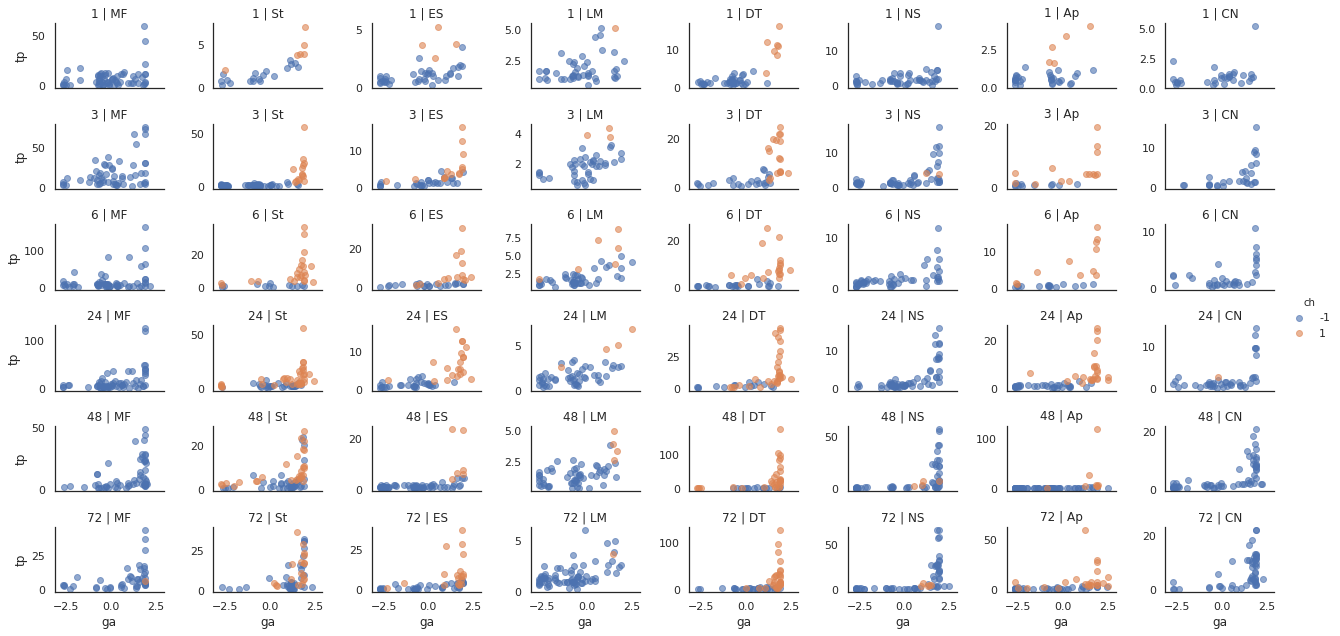

In [35]:
C1  = ['MF','St','ES','LM','DT','NS','Ap','CN']

g=sns.FacetGrid(FITS0,col='ft',row='timeh',height=1.5,aspect=1.5,
                col_order=C1,
                legend_out=True,sharey=False,
                hue='ch')
g.map(pl.scatter,'ga','tp',alpha=0.6)
g.add_legend()
g.set_titles(row_template='{row_name}',col_template='{col_name}')
#g.set(ylim=25)
g.savefig(FIG_DIR+'heprn-cr-tp-ga-v1.png')

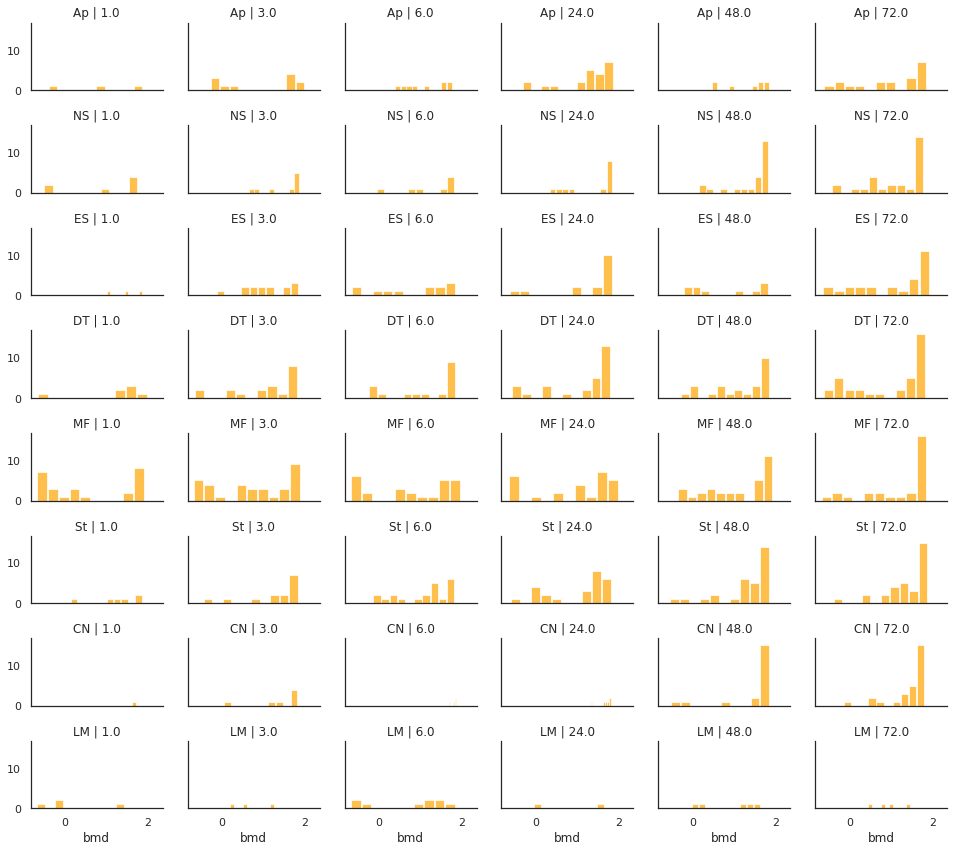

In [28]:
C1  = ['MF','St','ES','LM','DT','NS','Ap','CN']
sns.set(style='white')
g=sns.FacetGrid(BMD_z1,col='timeh',row='ft',height=1.5,aspect=1.5,
                sharey=True)
g.map(pl.hist,'bmd',bins=10,rwidth=0.9,color='orange',alpha=0.7)
g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.savefig(FIG_DIR+'heprn-assay-time-hits-v1b.png')

In [59]:
AC50[AC50.ft_ch=='CN_dn'].sort_values('bmd_um')

,bmd,bmd_um,bmr,bmr_type,ch,ft,ft_ch,ft_type,name,timeh
0,-0.61,0.24,50,E,-1.0,CN,CN_dn,single,Furfural,72.0
4,0.10,1.26,50,E,-1.0,CN,CN_dn,single,S-Bioallethrin,48.0
4,0.60,3.94,50,E,-1.0,CN,CN_dn,single,Endothal,72.0
4,1.12,13.06,50,E,-1.0,CN,CN_dn,single,Folpet,3.0
4,1.41,25.48,50,E,-1.0,CN,CN_dn,single,Mercuric chloride,72.0
4,1.41,25.99,50,E,-1.0,CN,CN_dn,single,Endothal,48.0
4,1.50,31.83,50,E,-1.0,CN,CN_dn,single,Mercuric chloride,48.0
3,1.52,32.87,50,E,-1.0,CN,CN_dn,single,Dithiopyr,72.0
4,1.54,35.05,50,E,-1.0,CN,CN_dn,single,Tetraconazole,72.0
3,1.56,36.34,50,E,-1.0,CN,CN_dn,single,Clodinafop-propargyl,72.0


In [8]:
from cr.tcpl import *

/home/ishah/ipynb/heprn-tp/lib3/cr/tcpl.py:156: RuntimeWarning: overflow encountered in power
  def calc_Resp(Tcpl):
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/ishah/ipynb/heprn-tp/lib3/cr/tcpl.py:156: RuntimeWarning: overflow encountered in power
  def calc_Resp(Tcpl):
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/ishah/ipynb/heprn-t

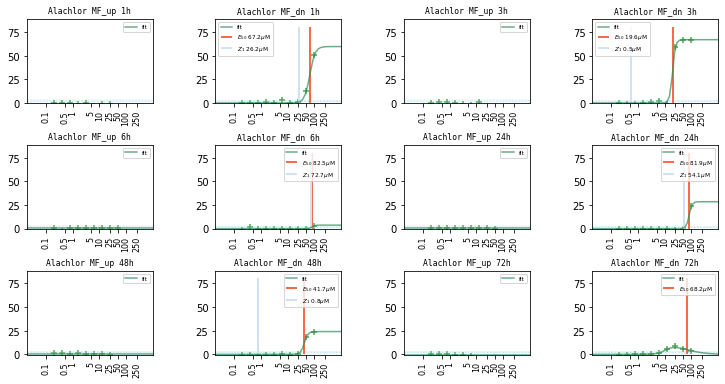

In [9]:
fig = plotFits('Alachlor',assay='MF',dbc=HCI.heprn_cr,nc=4,
               show_bmds=dict(E=[50],Z=[1]))
#fig.savefig(FIG_DIR+'alachlor-mf-v1a.png')

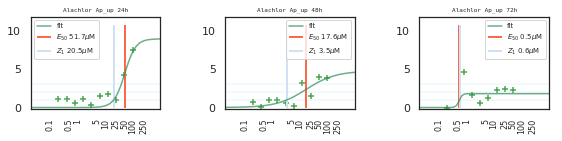

In [44]:
fig = plotFits('Alachlor',assay='Ap',dbc=HCI.heprn_cr,show_bmds=dict(E=[50],Z=[1]))
fig.savefig(FIG_DIR+'alachlor-ap-v1a.png')

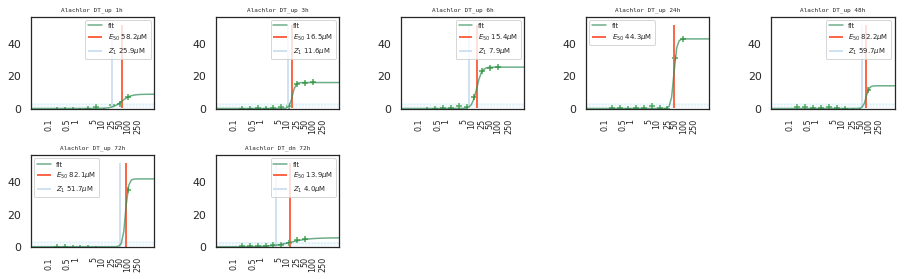

In [58]:
fig = plotFits('Alachlor',assay='DT',dbc=HCI.heprn_cr,show_bmds=dict(E=[50],Z=[1]))
fig.savefig(FIG_DIR+'alachlor-dt-v1a.png')

In [ ]:
HCI.heprn_cr.find_one({'name':'Alachlor','best_fit.model':{'$ne':'cnst'}})

In [61]:
X = np.round(10**BMDw.query("name=='Endothal'"),2).fillna('')
X.to_excel(DAT_DIR+'heprn-endothal-cr-v1a.xlsx')
X

ft                                  Ap    CN    DT    ES   LM   MF    NS   St  \
name     timeh bmr_type bmr ch                                                  
Endothal 6.0   Z        1    1.0                      71                        
         24.0  Z        1   -1.0          43                    43   2.1        
                             1.0    20          28    12                   25   
         48.0  Z        1   -1.0         4.7                    13   5.2        
                             1.0               4.5  0.92                  2.2   
         72.0  Z        1   -1.0        0.72              6.9  5.4  0.47        
                             1.0  0.95        0.49    85                   65   

ft                                bmd_min  
name     timeh bmr_type bmr ch             
Endothal 6.0   Z        1    1.0    70.68  
         24.0  Z        1   -1.0     2.12  
                             1.0    11.99  
         48.0  Z        1   -1.0     4.72  
                             1.0     0.92  
         72.0  Z        1   -1.0     0.47  
                             1.0     0.49

/home/ishah/ipynb/pb/heprn/lib/cr/tcpl.py:151: RuntimeWarning: overflow encountered in power
  ls = 1/(1+10**((x-la)*lw))
/home/ishah/ipynb/pb/heprn/lib/cr/tcpl.py:150: RuntimeWarning: overflow encountered in power
  gn = 1/(1+10**((ga-x)*gw))
/home/ishah/ipynb/pb/heprn/lib/cr/tcpl.py:147: RuntimeWarning: overflow encountered in power
  return tp/(1+10**((ga-x)*gw))


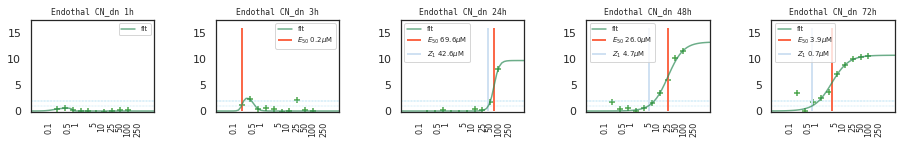

In [63]:
fig = plotFits('Endothal',assay='CN',dbc=HCI.heprn_cr,show_bmds=dict(E=[50],Z=[1]))
fig.savefig(FIG_DIR+'endothal-cn-v1a.png')

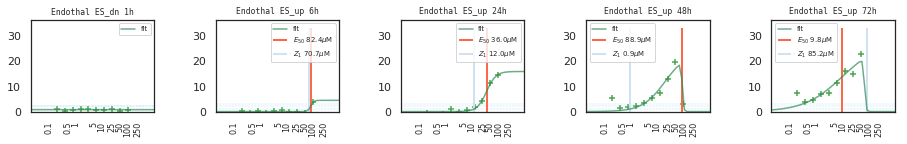

In [64]:
fig = plotFits('Endothal',assay='ES',dbc=HCI.heprn_cr,show_bmds=dict(E=[50],Z=[1]))
fig.savefig(FIG_DIR+'endothal-es-v1a.png')

## Calculate potency by l2fc

#### AC50 values

In [65]:
# from cr.tcpl import *
# from hci.fc import *
# from hci.traj import *

# va ='z_ctrl'
# ft  ='FA1'
# C1 = [u'Ap', u'CN', u'DT', u'ES', u'LM', u'MF', u'NS', u'St']

# for chem in HCI.chemicals.find(dict(stype='chem_test')).distinct('chem_name'):    
#     print chem
#     # Get the combined features for this chemical. To ensure the same combinations
#     # are use to generate the multivar features...

#     FCs = getChemFC(chem,feat=ft,val=va,pivot=True,what='cr',
#                     dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats)

#     FT1 = list(FCs.columns)
#     FC1=FCs.reset_index()
#     FC1['lconc']=np.log10(FC1.conc)

#     # Calculate univariate feature fits
#     SB1 = {k:1 for k in C1}
#     Hits1,CR,CR_ci= calc_TcplFits(FC1,FT=C1,SB0=SB1,conc_limit=False,
#                                 info=dict(ft_type='single',data=va))
#     break
#     if Hits1:
#         print "  Single hits: %i" % CR.shape[0]
#         HCI.heprn_cr.insert_many(Hits1)


1,1-Dimethylhydrazine
